# CHART Analysis Tutorial

The CHART data taking package produces two types of files -- a data file, and a metadata file. The data file will have a `.dat` extension, and the metadata has a `.metadata.npz`. Each observation should have an associated data and metadata file. The metadata has information about the data, such as the frequencies and times of the observation, and the data contains the observation. The CHART package generates a folder that contains all the data and metadata files for a single observation. You will need to run this notebook on the machine that contains your data. This could be the machine you used to take your data, or a machine that you have transferred your data onto. If you would just like to learn about the analysis steps, you can use the test data provided for this notebook.

In order to see the 21-cm signal from the galaxy, some data processing steps are needed. First, we do some simple calibration and plotting steps to look at our data.

## Data Processing and Plotting

First, we need to import the python packages used for the analysis. If you are using the provided Raspberry Pi image, these should already be installed. If you are not, you will need to install them with a package manager such as pip or conda, and will need to install the CHART package using the instructions on the github. Run the cell below to import the packages. You do not need to change anything in this cell.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import chart
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord, AltAz, ICRS
from astropy.time import Time
import pandas as pd
from ipywidgets import interact, FloatSlider, Dropdown
from scipy.stats import chi2
import scipy.constants as const

The cell below imports a few constants and useful functions. These constants and functions will be used in later steps of the code. Run the cell below to import the functions. You do not need to change anything in this cell.

In [11]:
f0 = 1.420405751768 * u.GHz

1.420405751768

In [12]:
longitude = -91.64
latitude = 44.0
elevation = 200
time = '2023-06-19T13:00:00'
altitude = 73.9
azimuth = 344.6
loc = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=elevation*u.m)
altaz = AltAz(obstime=Time(time), location=loc, alt=altitude*u.deg, az=azimuth*u.deg)
skycoord = SkyCoord(altaz.transform_to(ICRS))
location = EarthLocation.from_geodetic(longitude, latitude, elevation*u.m) #Lon, Lat, elevation
    

In [18]:
np.e

2.718281828459045

In [20]:
# A couple constants and useful functions for later.
f0 = 1.420405751768 * u.GHz
speed_of_light = const.speed_of_light * (u.meter / u.second)

def plot_f0(lims=[30, 40], xval=f0):
    plt.plot([xval, xval], lims, '--k', lw=0.5)

def freq2vel(freq, rest=f0):
    """
    Calculates velocity from measured frequency via doppler shift.
    
    :param freq: array of frequency quantities (including units)
    :param rest (optional): Rest frequency, defaults to 1.42 GHz
    :returns vel: velocity inferred by doppler shift
    """
    return -(freq - f0) * speed_of_light / freq

def LSR_shift(longitude, latitude, elevation, time, altitude, azimuth):
    """
    Identifies the exact postion at which the observations were taken and corrects for the Local Standard of Rest. 
    Along with this it also converts location, altitude, and azimuth to galactic coordinates.
    
    :param latitude: latitude in degrees
    :param longitude: longitude in degrees
    :param elevation: elevation in meters
    :param time: observation time in UTC format string
    :param altitude: altitude in degrees
    :param azimuth: azimuth in degrees
    """
    
    loc = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=elevation*u.m)
    altaz = AltAz(obstime=Time(time), location=loc, alt=altitude*u.deg, az=azimuth*u.deg)
    skycoord = SkyCoord(altaz.transform_to(ICRS))
    loc = loc.get_itrs(obstime=Time(time)) #To ITRS frame, makes Earth stationary with Sun 
    pointing_45deg = SkyCoord(altaz.transform_to(ICRS)) #Center of CHART pointing
    frequency = SpectralCoord(f0, observer=location, target=pointing_45deg) #Shift expected from just local motion
    f0_shifted = frequency.with_observer_stationary_relative_to('lsrk') #correct for kinematic local standard of rest
    f0_shifted = f0_shifted.to(u.GHz)
    v = -freq2vel(f0_shifted, f0)
    v_adjustment = v.to(u.km/u.second)
    return v_adjustment, skycoord.galactic

def find_array_with_number(freqs, pointing, number):
    for k_index, k in enumerate(freqs[pointing]):
        if numpy.any((k[:-1] <= number) & (number <= k[1:])):
            return k_index, k
    return None, None

def average_overlapping(x1, y1, x2, y2):
    """
    Averages the y values where the x values are shared between two arrays and keeps y values for x values that are not shared.
    
    :param x1: First x array
    :param y1: First y array
    :param x2: Second x array
    :param y2: Second y array
    :return: Tuple of combined x values and averaged/kept y values
    """
    # Find the unique x values in both arrays
    unique_x = np.union1d(x1, x2)
    
    # Create an array to store the averaged/kept y values
    avg_y = np.zeros_like(unique_x)
    
    # Iterate over the unique x values
    for i in range(len(unique_x)):
        # Find the indices of the current x value in the two x arrays
        ind1 = np.where(x1 == unique_x[i])[0]
        ind2 = np.where(x2 == unique_x[i])[0]
        
        # If the current x value is in both arrays
        if len(ind1) > 0 and len(ind2) > 0:
            # Compute the average of the two corresponding y values
            avg_y[i] = (y1[ind1[0]] + y2[ind2[0]]) / 2
        # If the current x value is only in the first array
        elif len(ind1) > 0:
            # Keep the corresponding y value from the first array
            avg_y[i] = y1[ind1[0]]
        # If the current x value is only in the second array
        elif len(ind2) > 0:
            # Keep the corresponding y value from the second array
            avg_y[i] = y2[ind2[0]]
    
    return unique_x, avg_y


def interactive_plot(unique_x):
    """
    Creates a plot that can be modified with sliders.
    
    param unique_x: x values of overlapping CHART data
    """
    x = unique_x
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    a = b = c = [1]*4

    lines = [ax.plot(x, (a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2)))))))[0] for i in range(4)]
    lines.append(ax.plot(x, sum([a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2))))) for i in range(4)]))[0])

    sliders = [FloatSlider(min=-100, max=100, step=1, value=1) for _ in range(12)]
    sliders = np.arry(sliders)
    colors = ['black']*4 + ['red']
    color_dropdowns = [Dropdown(options=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'], value=colors[i]) for i in range(5)]
    
    def update(a=[1] * 4, b=[1] * 4, c=[1] * 4,
               colors=['black', 'black', 'black', 'black', 'red']):
        
        for i in range(4):
            lines[i].set_ydata((a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2)))))))
        lines[4].set_ydata(sum([a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2))))) for i in range(4)]))
        for i in range(5):
            lines[i].set_color(colors[i])
        fig.canvas.draw_idle()

    interact(update, a=sliders[0::3], b=sliders[1::3],
             c=sliders[2::3],colors=color_dropdowns)
     
    return ax

    
def goodness_of_fit(unique_x, combined_gauss, avg_y):
    """Performs a chi-squared goodness of fit test between the CHART data and the user created combined Gaussian curve.
    
    param unique_x: x values of overlapping CHART data
    param combined_gauss: y values of combined Gaissian curve
    param avg: y values of overlapping CHART data
    """
    # Only include data within 100 km/s
    mask = (unique_x >= -100) & (unique_x <= 100)
    gauss_masked = combined_gauss[mask]
    data_masked = avg_y[mask]

    chi_squared_statistic = np.sum((gauss_masked - data_masked)**2 / data_masked)

    p_value_y = chi2.sf(chi_squared_statistic, len(gauss_masked) - 1)

    print("P-value for y: ", p_value_y)

Now we read in our data. Each observation you took should have produced a directory with a time and date. The `data_dir` parameter indicates the larger file tree where your observations are located (you can find this in the linux terminal by typing `pwd`. Here, ours is called `'test_data/'`. The `paths` parameter is a list of your observations within the `data_dir` directory. There may be more or less than three depending on how many observations you took, you can simply add more to the list if you have more than three. If you would like to use the test data, you do not need to change anything in this cell. However, if you would like to use your own data, you will make some modifications.

We have two variables in the next cell you will need to change to use your own data. Python variables are containers for storing values that we want to reuse later. For example, if we want to reuse the number 1.4204 for the 21-cm line many times, we could call this variable 21cm and set it equal to 1.4204 by typing 21cm = 1.4204, and then in the future if we want to have the code use the number 1.4204 we can just tell it to use 21cm. This is convinient for values you will use multiple times. Here, we will use it to tell the code what our data files are called and where they are located. 

We have two variables in the next cell at the top called data_dir and paths. The data_dir variable tells the code where the data is located, and the paths tell it what the data is called. The data_dir variable is equal to a single value wrapped in quotes, called a 'string' in Python. The paths variable is a list of strings. In python a list is put in brackets [] and the individual list values are separated by commas.

For the tutorial data, your data is located at 'test_data/' and your three observations are called 'abeardsley_Winona-HS-Park_2022.10.08_1_6:12_pm', 'abeardsley_Winona-HS-Park_2022.10.8_2_6:25_pm', and 'abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm'. 


Each comma separated value in the paths list represents what we call a 'pointing'. A pointing is an observation made in a specific direction that can be defined by its altitude and azimuth, its celestial coordinates, or its galactic coordinates. We will discuss what these coordinates mean later.

Replace the file directory and the file names into the first two lines below, replacing the data_dir and paths variables. If you aren't sure where your data is located, refer to the analysis tutorial page at astrochart.github.io to see how to find it. Make sure you wrap the paths and file names in quotes as is done for the tutorial.

Now, run the cell below. It will print out some information about each observation from your metadata, such as the data, time, and center frequency, as well as a few other parameters.

In [90]:
data_dir = 'test_data/'
paths = ['abeardsley_Winona-HS-Park_2022.10.08_1_6:12_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_2_6:25_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm']

ntrials = len(paths)

data = []
mdata = []
bps = []  # bandpasses

for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    # Rough estimate for bandpass
    nchans = m[0]['vector_length']
    levels = np.median(d[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
    rescaled = d / levels.reshape(-1, 1, 1)
    bp = np.median(rescaled, axis=(0, 1))
    bps.append(bp)

for i in range(ntrials):
    print('Trial: '+str(i))
    chart.analysis.print_meta(m[i])

Trial: 0
date :	 2022-10-08
start_time :	 1665271803.061299
end_time :	 1665271814.9317102
samp_rate :	 2000000.0
frequency :	 1410000000.0
vector_length :	 1024
int_length :	 976
data_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-03.562153.dat
metadata_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-03.562153.metadata.npz
Number of time integrations:	20
dtype :	 [<class 'numpy.float32'>]
Trial: 1
date :	 2022-10-08
start_time :	 1665271803.061299
end_time :	 1665271826.6499507
samp_rate :	 2000000.0
frequency :	 1411000000.0
vector_length :	 1024
int_length :	 976
data_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-15.541138.dat
metadata_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-15.541138.metadata.npz
Number of time integrations:	20
dtype :	 [<class 'numpy.float32'>]
Trial: 2
date :	 2022-10-08
start_time :	 1665271803.061299
end_

The next three cells plot the raw CHART data for each pointing. The x-axis represents the recorded frequencies in Gigahertz and the y-axis shows the signal strength in decibels (dB) for each frequency. Each color represnts a different 'tuning' in the data. The software defined radio used for taking data has a limited frequency range, and can only digitize 2 MHz worth of data at a time. In order to scan a larger frequency range, the SDR must do it in steps, or 'tunings'. It will be difficult to see anything in the data in these plots, as a few further calibration steps are needed. The vertical blue line indicates the rest frequency of neutral hydrogen. You do not need to make any modifications to this cell.

Text(0.5, 0, 'Frequency [GHz]')

<Figure size 432x288 with 0 Axes>

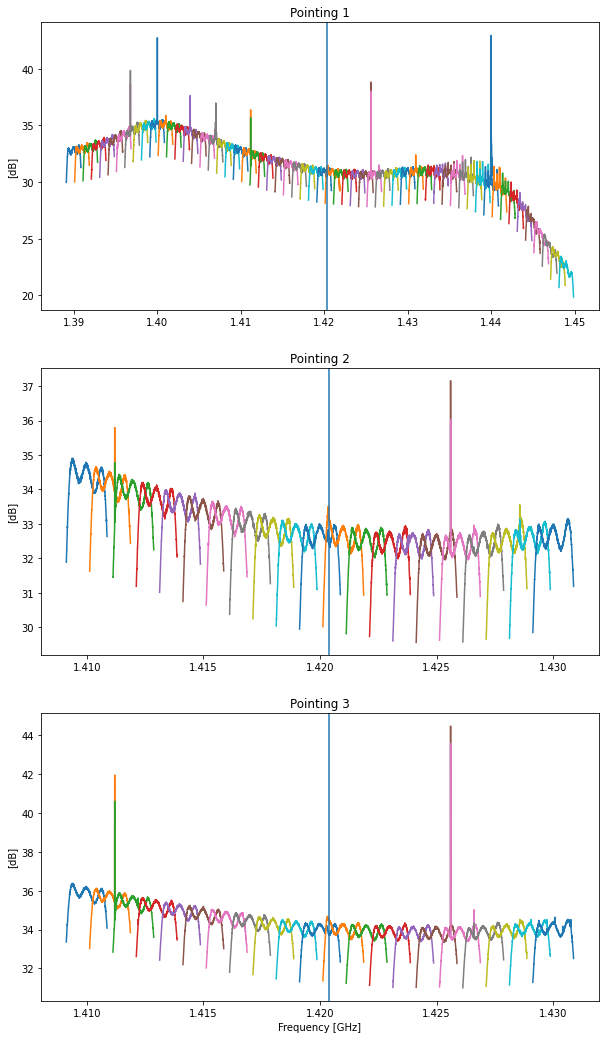

In [94]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) 
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

    for k in range(len(spectra[pointing]) - 1):
        spec1 = spectra[pointing][k]
        spec2 = spectra[pointing][k + 1]
        freq1 = freqs[pointing][k]
        freq2 = freqs[pointing][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[pointing][k + 1] = spec2

plt.figure()
fig, axs = plt.subplots(ntrials, 1, figsize=(10,18))
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(1.4204)
#plt.xlim(1.42,1.421)   
plt.xlabel('Frequency [GHz]')

Now, we will correct for the bandpass of the software defined radio.
After the data is collected from the antenna it passes through a bandpass filter located in our SDR. A bandpass filter is used to isolate a specific frequency range of interest from the broader spectrum of electromagnetic radiation received by the telescope. This filter allows signals within the desired bandpass to pass through with little interference while blocking signals outside that range. However, this bandpass filter has a frequency-dependent response that imparts a shape onto our data. This is the repeating stucture seen in each tuning above. The next cell will calibrate for this bandpass, removing that shape from the data. There still may be some overall shape across the whole frequency range caused by frequency dependence of the electronics, but we don't worry about that as our 21-cm signal is in a fairly narrow range. If the 21-cm signal is visible in your data, you should now be able to see it near the line that indicates the rest frequency after running the cell below! You do not need to make any modifications to this cell.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Frequency [GHz]')

<Figure size 432x288 with 0 Axes>

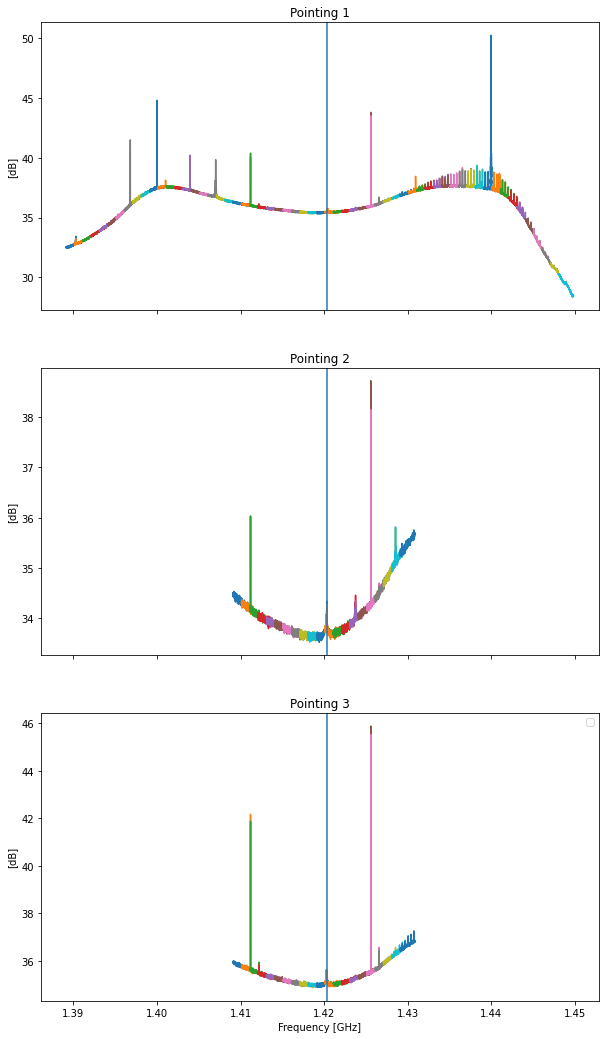

In [95]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) /bps[0]
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

    for k in range(len(spectra[pointing]) - 1):
        spec1 = spectra[pointing][k]
        spec2 = spectra[pointing][k + 1]
        freq1 = freqs[pointing][k]
        freq2 = freqs[pointing][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[pointing][k + 1] = spec2
        
plt.figure()
fig, axs = plt.subplots(ntrials, 1, sharex=True, figsize=(10,18))
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(1.4204)
#plt.xlim(1.42,1.421)   
plt.legend()
plt.xlabel('Frequency [GHz]')

## Calibrating and Comparing to Survey Data

Now, we can check our data against known Milky Way data. The first task is to figure out exactly where in the sky your telescope was pointed.

There are a few ways to identify positions in space. One is the celestial coordinate system. Right Ascension (RA) and Declination (Dec) are a system of coordinates used in astronomy to determine the location of stars, planets, and other objects in the night sky. They are similar to the system of longitude and latitude used to locate places on Earth. Right Ascension corresponds to longitude and Declination to latitude. 

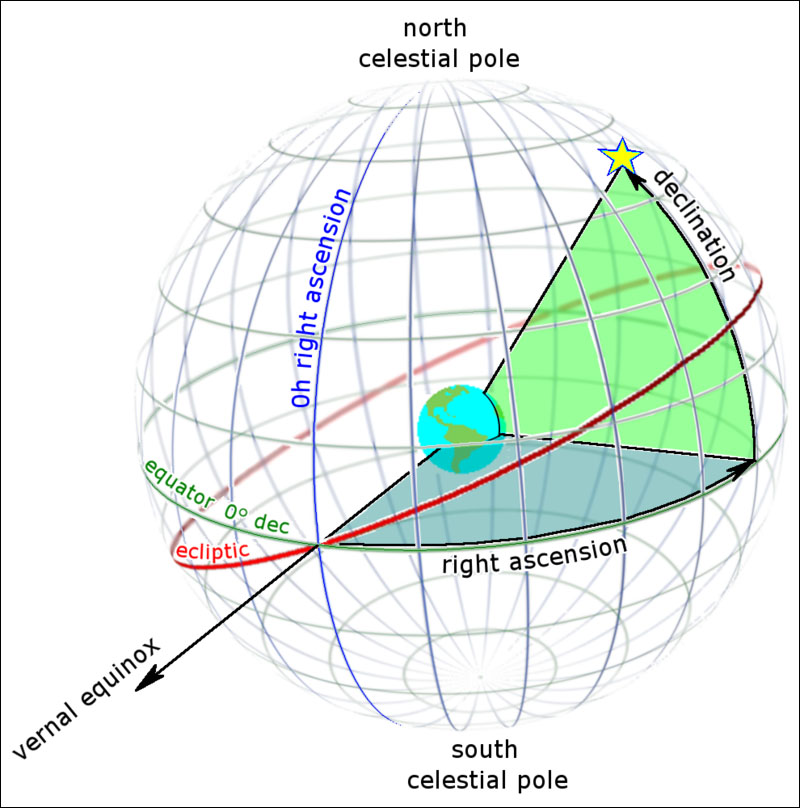
Image link: https://skyandtelescope.org/astronomy-resources/right-ascension-declination-celestial-coordinates/

Another is the galactic coordinate system. Galactic coordinates are a system of coordinates used in astronomy to determine the location of objects in the Milky Way galaxy. The system uses the Sun as its center, with the primary direction aligned with the approximate center of the Milky Way galaxy.

There are two coordinates in this system: galactic longitude (l) and galactic latitude (b). Galactic longitude is measured with the primary direction from the Sun to the center of the galaxy in the galactic plane, while galactic latitude measures the angle of the object above the galactic plane. 

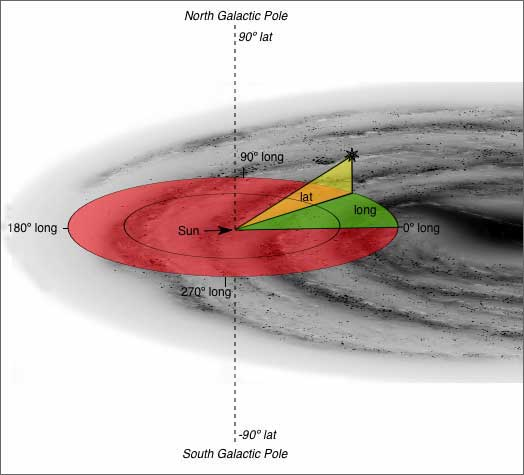
Image link:https://astronomy.ua.edu/undergraduate-program/course-resources-astronomy/lab-exercise-8-cosmic-distributions-and-the-galactic-ecology/1293-2/

The images below show the telescope's line of sight (top) and field of view (bottom) from two perspectives, one looking at the galaxy from a top-down view, and the other showing the area of the sky observed from Earth's surface. The FOV is the extent of the observable area measured in degrees that the telescope can see. Within the direction that the telescope is pointed towards, there are multiple neutral hydrogen clouds. If you look at the line of sight figure, you can see that the arrows cross through multiple parts of the galaxy. Gas from these areas will be moving at different velocities and directions. 

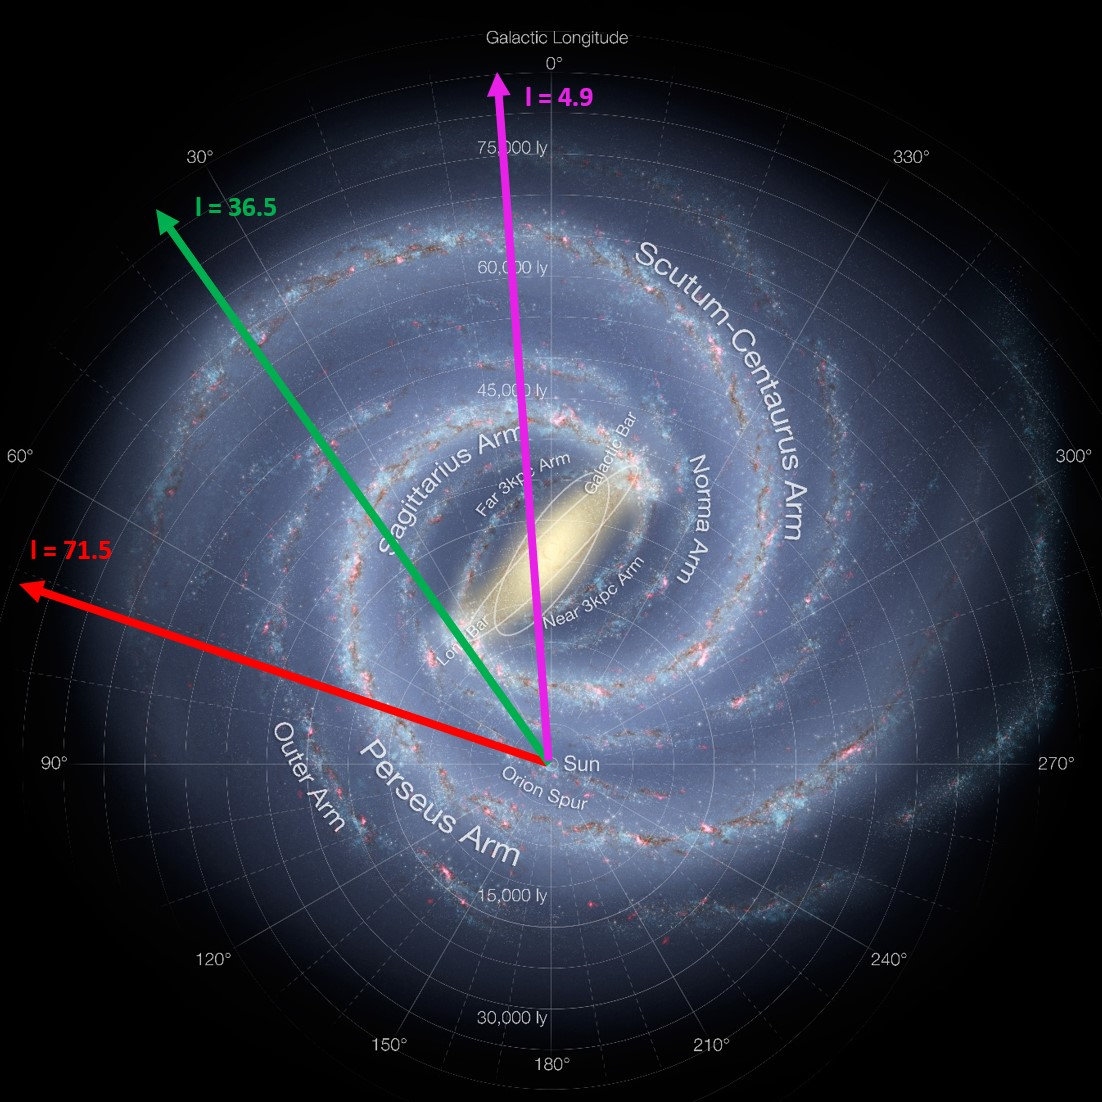

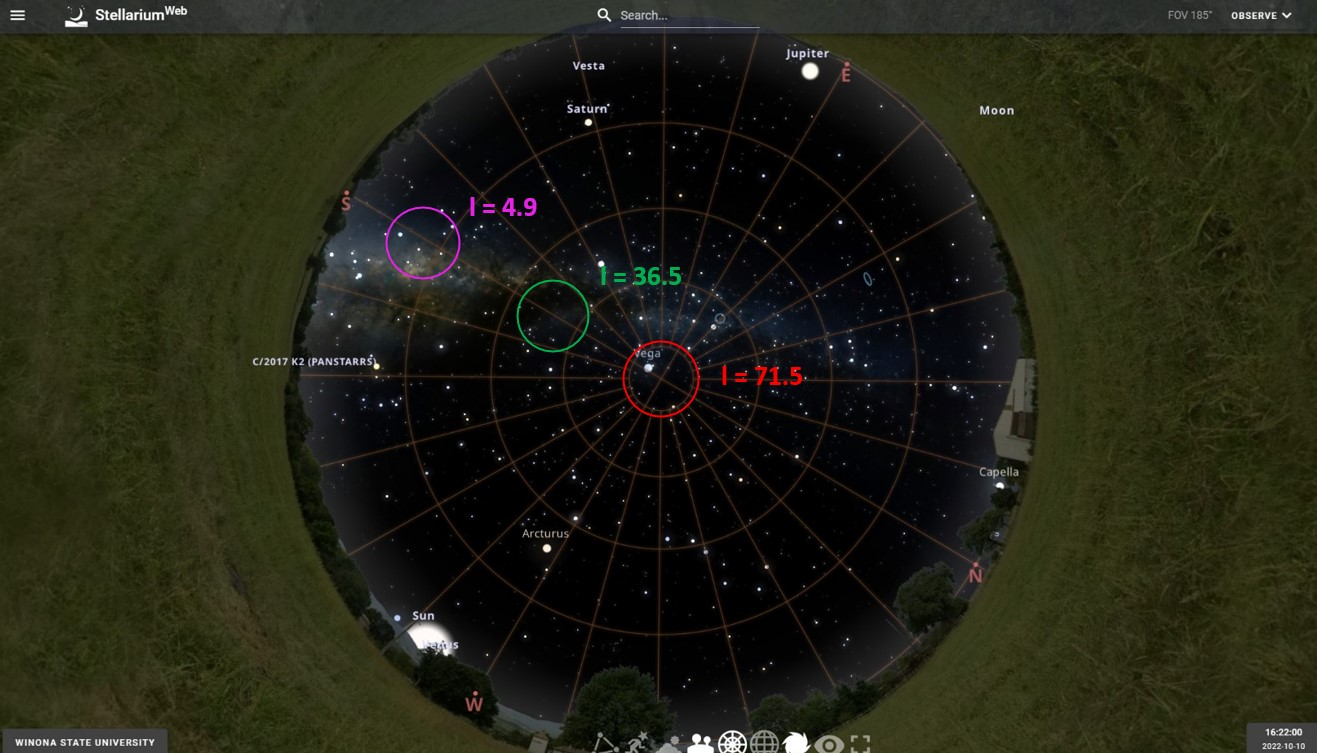

Here is the information about the test data used here, taken in Winona Minnesota on October 8th, 2022.

Pointing 1:
Long edge of horn oriented E-W
pointed 0 deg N-S, 4 deg to the East
Default observing parameters
Started 6:12pm

Pointing 2:
Tilted down, 37 deg S of vertical
Freqs 1410-1431
Started 6:25pm

Pointing 3:
Laying down toward S, elevation=17deg
Same freqs as Trial 2
Started 6:30pm

The cell below does some convienient variable setting for later. You will need to make some modifications to this cell if you want to use your own data. The first three variables called Observation_longitude, Observation_latitude , and Observation_elevation correspond to the longitude of the observation location in degrees, latitude of the observation location in degrees, elevation of the observation location in meters. You can find these values for your observing location if you are not using the test data. You do not need to wrap these in quotes, as they are not the string type data we used before. These values are what is called a 'float' in python, which is a type of number.

The next three variables are lists with data that corresponds to each of your pointings. The Observation_azimuths is the azimuthal angle of your observation in degrees, the Observation_altitudes is the altitude angle of your observation in degrees, and the Observation_datetimes is the date and time in the format Year-Month-DayTh:m:s . You need to make sure to use the UTC time zone, which you can find an online converter to obtain.


In [97]:
### Pointing Dict setup 
Observation_longitude = -91.64419
Observation_latitude = 44.04672
Observation_elevation = 200
Observation_azimuths = [360, 180, 180]
Observation_altitudes = [90, 53, 17]
Observation_datetimes = ['2022-10-8T23:12:00', '2022-10-8T23:25:00', '2022-10-08T23:30:00']

For each pointing, we will have to do some calibration on the CHART data to effectively compare with a known survey.  We will use the Leiden/Argentine/Bonn (LAB) Survey. The LAB Survey is a project that mapped the 21-cm gas with two telescopes, one in the Netherlands and one in Argentina. The LAB survey has published a simulator based on this data, which you can use to extract the expected spectrum for the coordinates your telescope was pointed at. We can use this spectrum to calibrate our spectra, and then compare the shapes to see if they match.

However, we first need to make a reference frame transform to ensure the CHART data and the simulation data are in the same observation frame. The LAB survey uses the Velocity at Local Standard of Rest reference frame, whereas the CHART data is in the natural frame of reference of the observer. The Local Standard of Rest (LSR) is a way for astronomers to measure the motion of objects in our galaxy, the Milky Way, with reference to our local solar neighborhood. This frame removes the peculiar motion of the earth and sun, and puts the observer stationary with the mean flow of motion in our part of the Milky Way.

The cell below will print out the velocity adjustment to transform to the LSR frame, as well as the Galactic coordinates that correspond to the altitude and azimuth pointing you input. Astropy may give a warning, this can be safely ignored. You do not need to make any modifications to this cell.

In [110]:
v_adjustments = []
galactic_ls = []
galactic_bs = []

for n in range(ntrials):
    v_adjustment, galactic_coords = LSR_shift(Observation_longitude, Observation_latitude, Observation_elevation, 
                                              Observation_datetimes[n], Observation_altitudes[n], Observation_azimuths[n])
    l = galactic_coords.l
    b = galactic_coords.b
    v_adjustments.append(v_adjustment)
    galactic_ls.append(round(l.degree,2))
    galactic_bs.append(round(b.degree,2))
    print('Pointing ' + str(n+1) + ' galactic longtiude: ', round(l.degree,2))
    print('Pointing ' + str(n+1) + ' galactic latitude: ', round(b.degree,2))

Pointing 1 galactic longtiude:  71.54
Pointing 1 galactic latitude:  24.72
Pointing 2 galactic longtiude:  36.52
Pointing 2 galactic latitude:  8.48
Pointing 3 galactic longtiude:  4.89
Pointing 3 galactic latitude:  -8.97


Once you have the galactic coordinates head to this website: https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php .
This database allows you to extract hydrogen profiles from the Leiden/Argentine/Bonn (LAB) Survey. 

Input the galactic coordinates and the Effective beamsize FWHM, which for CHART is 25 degrees, however we will put in 20 due to limitations of the simulator. The beam size of a telescope is the angular size of the area that the telescope can “see” at once. 

Download the H1 profile file and upload it to Jupiter Notebook. 

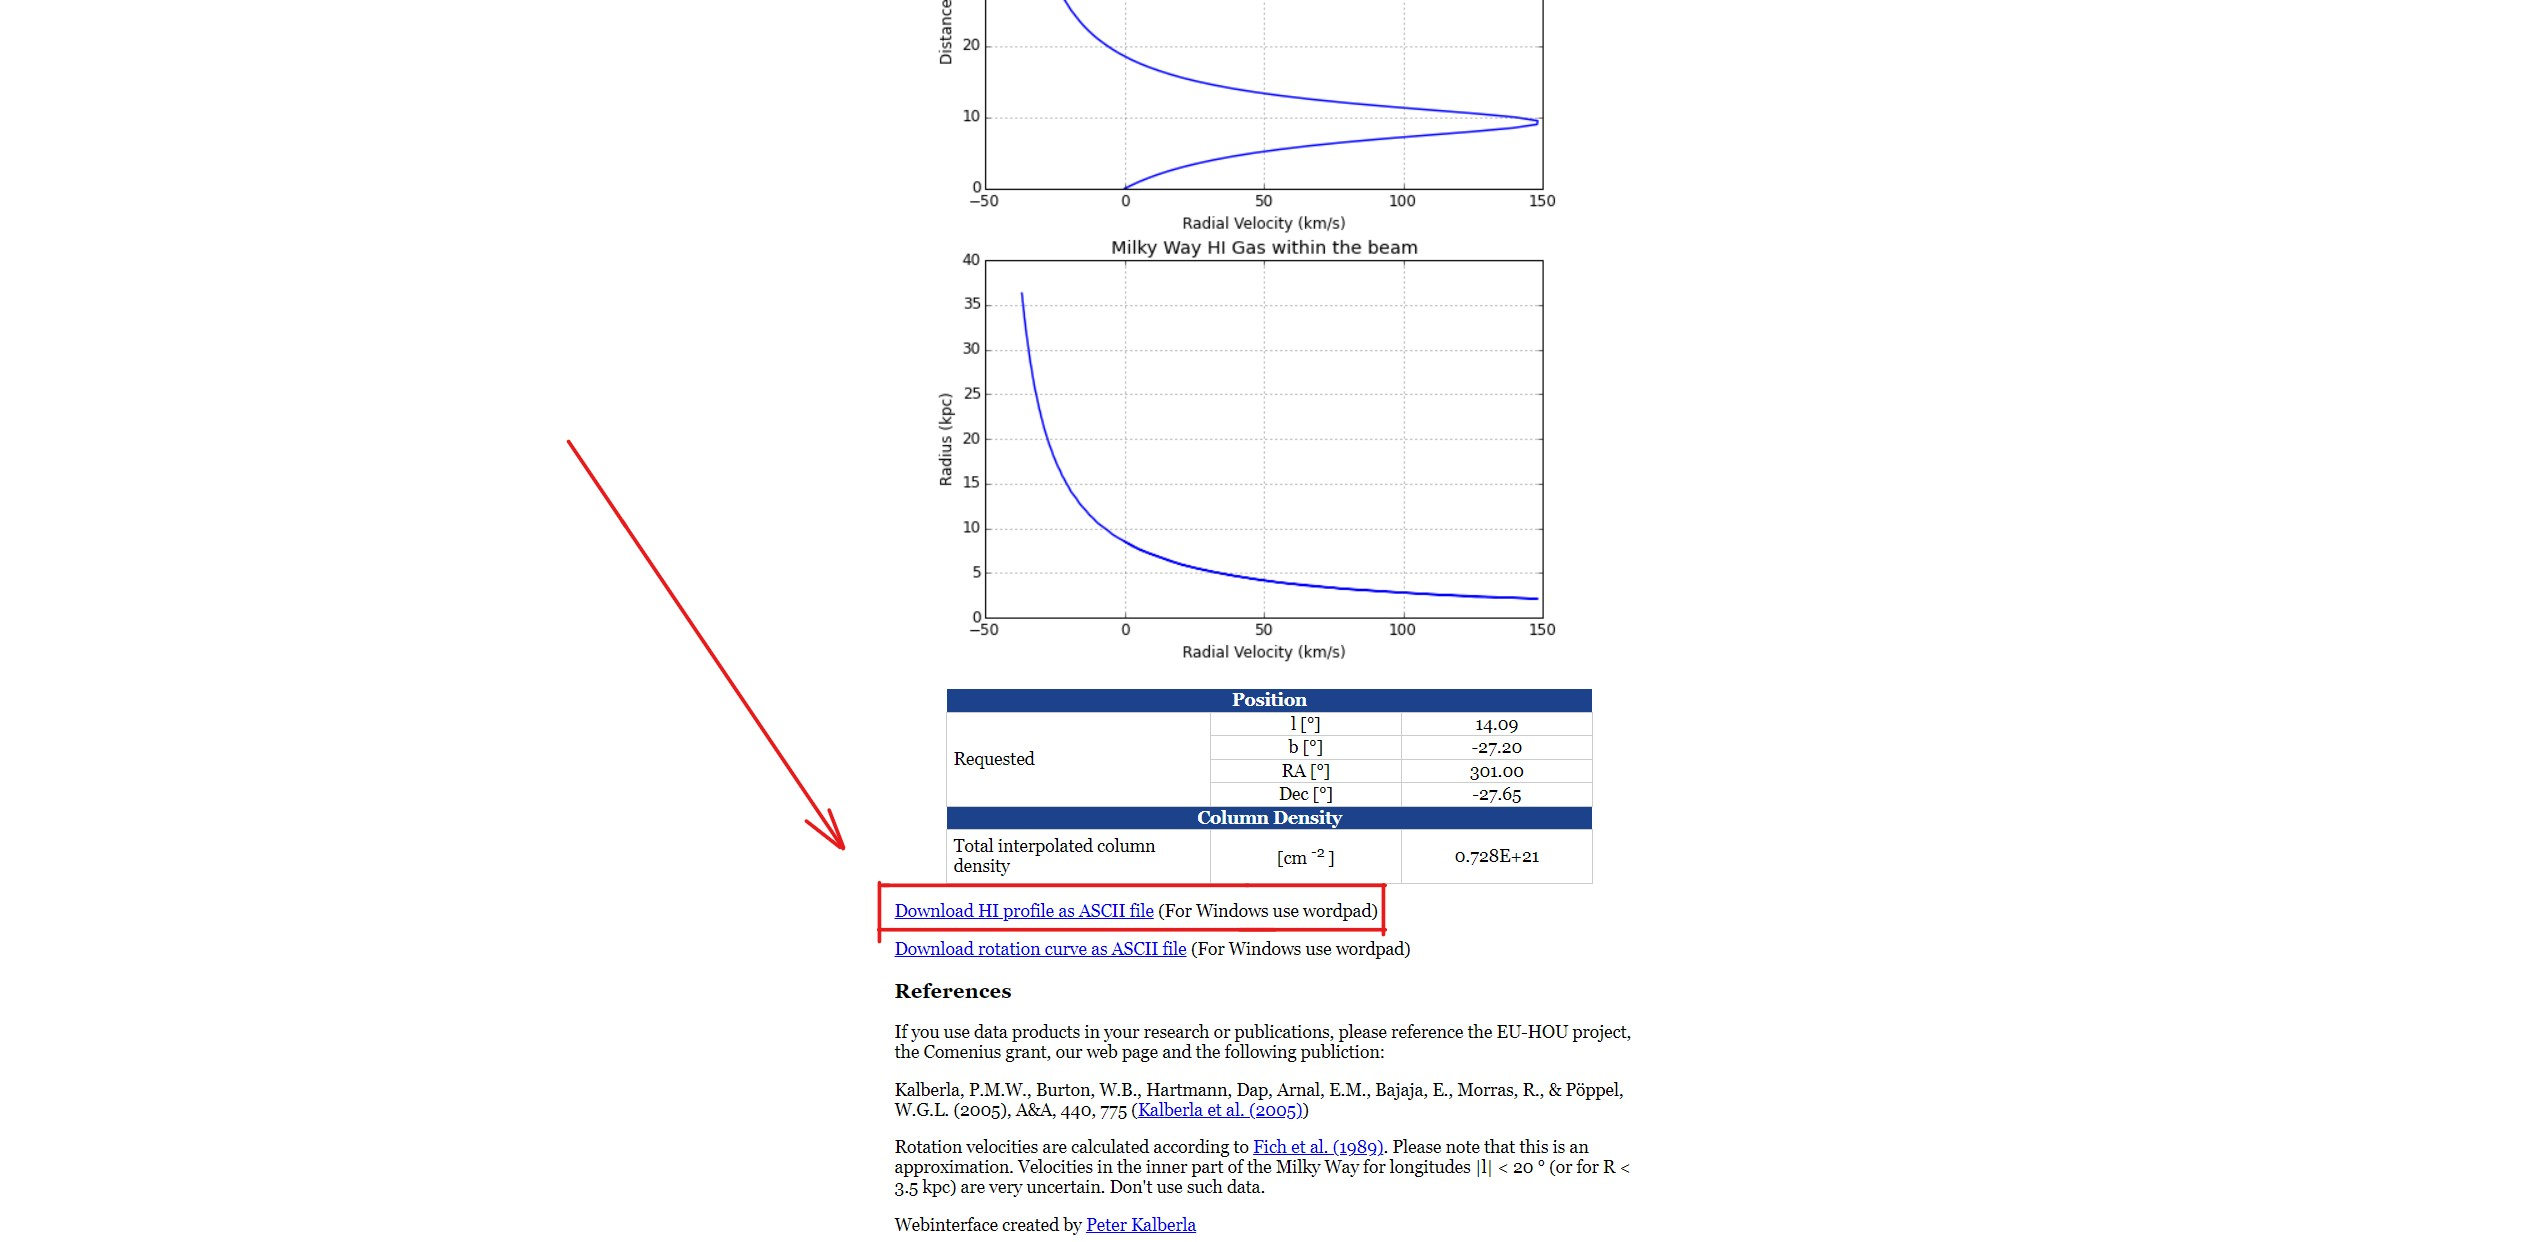



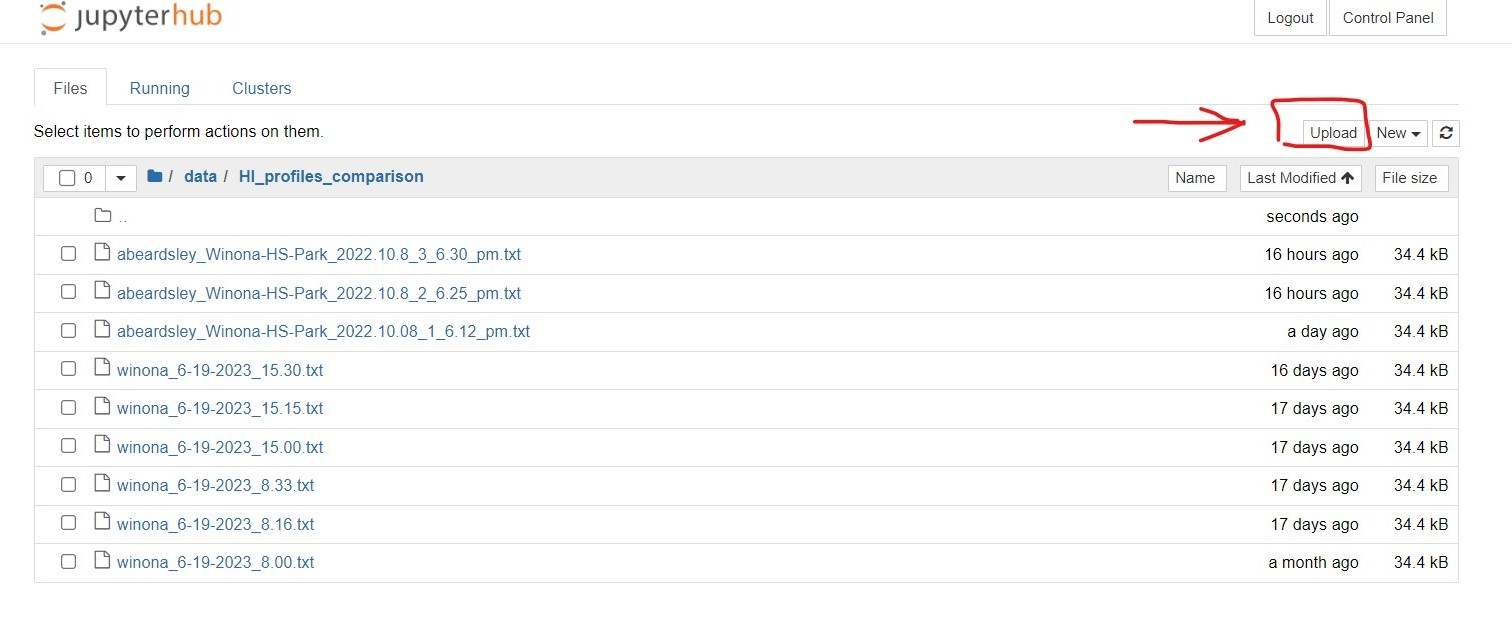

Depending on where you put your text files, you can use the 'pwd' command in your terminal to find the path. Input the appropriate path instead of the 'test_data/abeardsley_Winona-HS-Park_2022.10.08_1_6.12_pm.txt' below. Do one for each pointing you have, and input into the "comps" list. You need to wrap in quotes again, since the data is a string. Make sure the file names are in the same order as the pointing they belong to! Then, run the cell, and the comparison profiles will be loaded into the notebook.

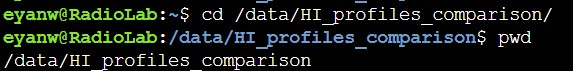

In [111]:
comps = ['test_data/abeardsley_Winona-HS-Park_2022.10.08_1_6.12_pm.txt', 'test_data/abeardsley_Winona-HS-Park_2022.10.8_2_6.25_pm.txt', 'test_data/abeardsley_Winona-HS-Park_2022.10.8_3_6.30_pm.txt']

Now we will transform our data one more time, to turn our frequencies into velocities.

Have you ever noticed that the sound that comes from a car that is coming towards you sounds different than the sound that comes from the same car as it is moving away from you? That is because the sound waves are being condensed and stretched depending on the car’s position relative to your own. This is an example of the Doppler Effect. 

![Doppler Shift Example](https://flypaper.soundfly.com/wp-content/uploads/2018/01/doppler-effect-header.jpg)

Image Link: https://flypaper.soundfly.com/wp-content/uploads/2018/01/doppler-effect-header.jpg

The same thing occurs with radio waves as objects in the universe move closer and farther away from us. The hydrogen clouds that the telescope detected are moving constantly and in order to find their velocity we have to use the Doppler shift equation. 

![Doppler Shift Equation](https://physicsopenlab.org/wp-content/uploads/2020/09/dopplerFormula2.png)

This is the Doppler shift equation where fe is the rest frequency or the frequency of the hydrogen in a lab when it is not moving, fo is the wavelength we observe, c is the speed of light, and v is the velocity in km/s. By using this equation we can get accurate velocities of the hydrogen clouds in relation to us. The cell below does this calculation. 

The cell below will also perform the last calibration step  using the simulated spectrum from the LAB survey. Data taken with a radio telescope has effects imposed on it by the instrument. One of these effects is called the telescope 'gain'. The gain is any amplification applied to the astronomical signal by the telescope, which happens, for example, with the analog amplifier we use for CHART. In order to know what the original astronomical signal looks like, we need to calibrate for how much gain was applied to the signal. There are a number of ways to do this calibration, but here we will use the LAB survey as a 'sky model'. Using a known measurement of the sky, we can adjust our signal amplitude to be the correct level for the known Milky Way at our coordinates. 

We also need to adjust for something called 'noise'. Noise is any generated signal that we see that is not our astronomical signal, which can come from, for example, the thermal noise of our electronics. This noise is added to our data, so we call it an 'additive' source, while the gain is a multiplication. We then have an equation that looks like:

CHART data = Astronomical signal * Gain + Noise 

and we want to find out the gain and noise parameters so we can rearrange the equation to get the real astronomical signal:

Astronomical signal = (Chart data - Noise)/Gain 

This is a simplification of the real world, and we make assumptions here, like the noise and gain being the same for every frequency. However, it works well to get a simple calibration.  The gain and noise will be automatically be calculated and applied by the next cell. 

Run the cell below. The CHART data and simulated model data are plotted as different colors. Then, you can evaluate how well your data matches the shape of the model!  

<IPython.core.display.Javascript object>


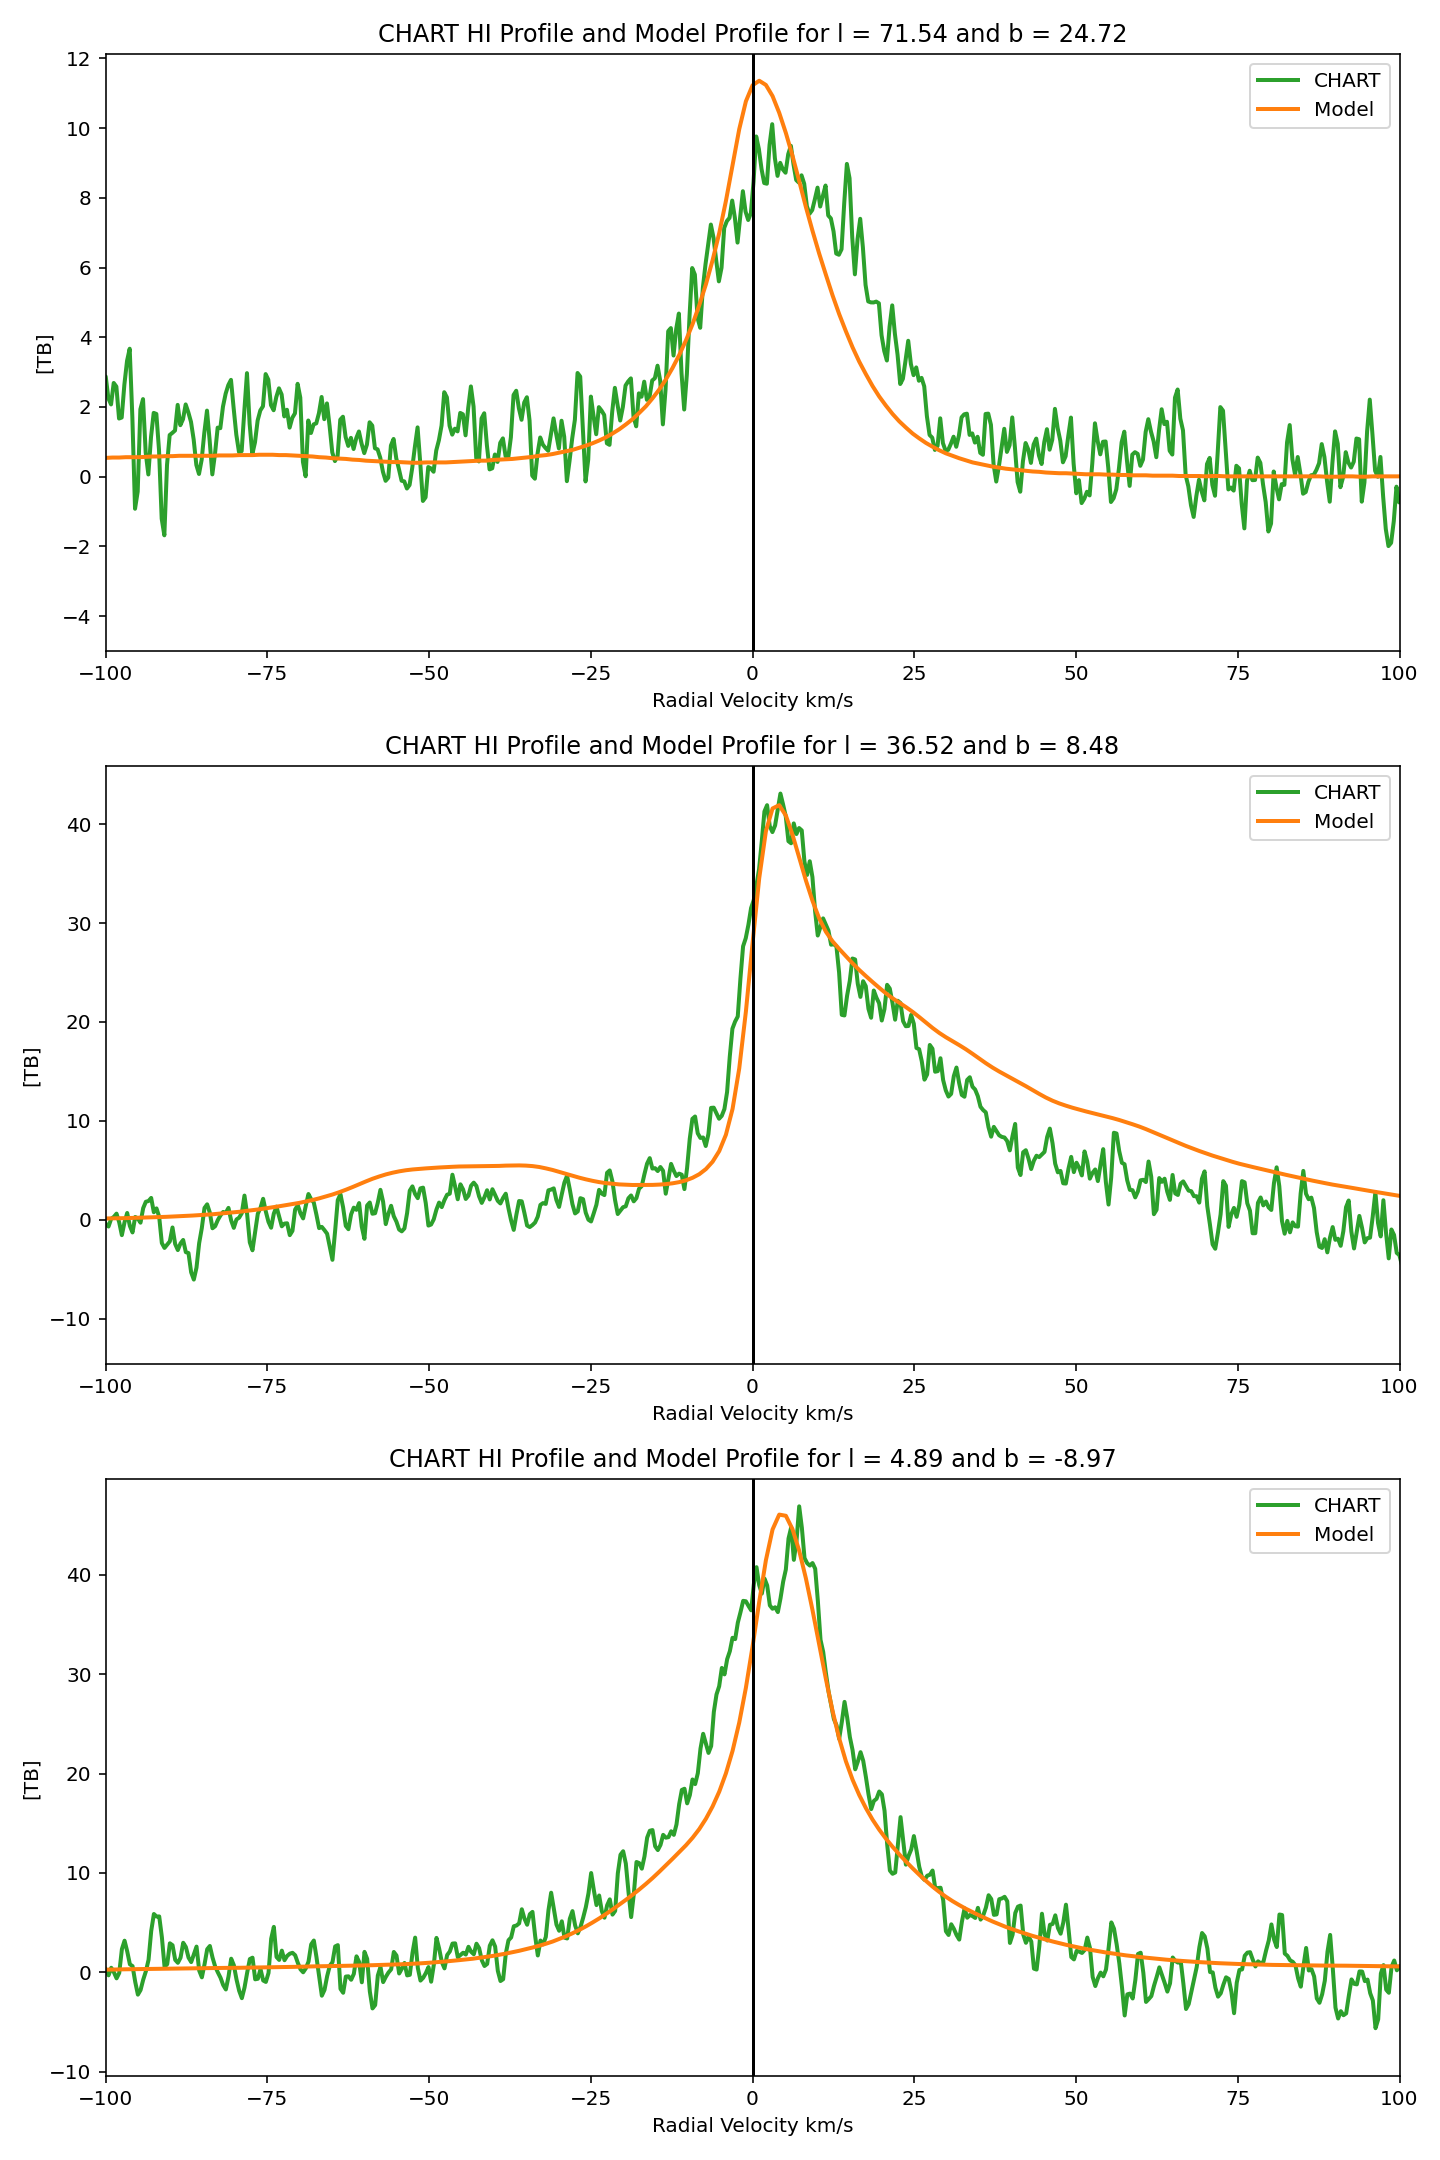

In [112]:
fig, ax = plt.subplots(ntrials)
fig.set_size_inches(10, ntrials*5)

noises = []
gains = []

for i in range(ntrials):


    pointing = i
    number = 1.4204

    k_index, result = find_array_with_number(freqs, pointing, number)
        
    sh_comp = pd.read_table(comps[i],skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')
    compTB = sh_comp['T_B']

    v_adjustment = v_adjustments[pointing]

    x1 = np.array((f2v(freqs[pointing][k_index]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
    x2 = np.array((f2v(freqs[pointing][k_index+1]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)

    vneg75 = min(range(len(x1)), key=lambda i: abs(x1[i]-75))
    vneg100 = min(range(len(x1)), key=lambda i: abs(x1[i]-100))
        
    noise = np.mean(10**((spectra[pointing][k_index][vneg100:vneg75])/10))
    gain = max(10**(spectra[pointing][k_index+1]/10)-noise)/(max(compTB))
    
    noises.append(noise)
    gains.append(gain)

    y1 = np.array((10**(spectra[pointing][k_index]/10) - noise)/gain)
    y2 = np.array((10**(spectra[pointing][k_index+1]/10) - noise)/gain)
    unique_x1, avg_y1 = average_overlapping(x1, y1, x2, y2)


    ax[i].plot(unique_x1, avg_y1, 'tab:green', linewidth=2, label = 'CHART')
    ax[i].plot(sh_comp['v_lsr'],compTB,'tab:orange', linewidth=2, label = 'Model')

    ax[i].axvline(0, color ='k')
    ax[i].set_xlim(-100,100)
    ax[i].set_ylabel('[TB]')
    ax[i].legend(loc='best')
    ax[i].set_xlabel('Radial Velocity km/s')
    ax[i].set_title('CHART HI Profile and Model Profile for l = ' + str(galactic_ls[pointing]) + ' and b = ' + str(galactic_bs[pointing]) )

    plt.tight_layout()

What do you notice here? How well do you think your fits worked? What sources of error can you come up with?

## Rotation Curve 

Now, we will use the calibrated data to compute an approximate rotation curve of the Milky Way galaxy. A rotation curve is a plot that shows how the orbital velocity of objects in a galaxy changes with their distance from the center of the galaxy. In other words, it shows how fast different parts of a galaxy are rotating around its center. Rotation curves are essential tools for studying the structure and dynamics of galaxies, as well as for understanding the distribution of mass within galaxies. By analyzing the shape of a galaxy’s rotation curve, scientists can learn about the distribution of visible and dark matter within the galaxy. 

The figure below shows a rotation curve of the M33 galaxy, constructed from actual measurements of stars and hydrogen clouds. The "expected from visible disk" curve shows what the expected rotation curve of M33 would look like if we added up all the matter we can see and compute what the rotation curve should look like. You will notice a discrepancy. This tells us that our model of rotation curves is missing something, and astronomers believe that something to be dark matter causing the rotation at the edges of galaxies to be much faster than expected.

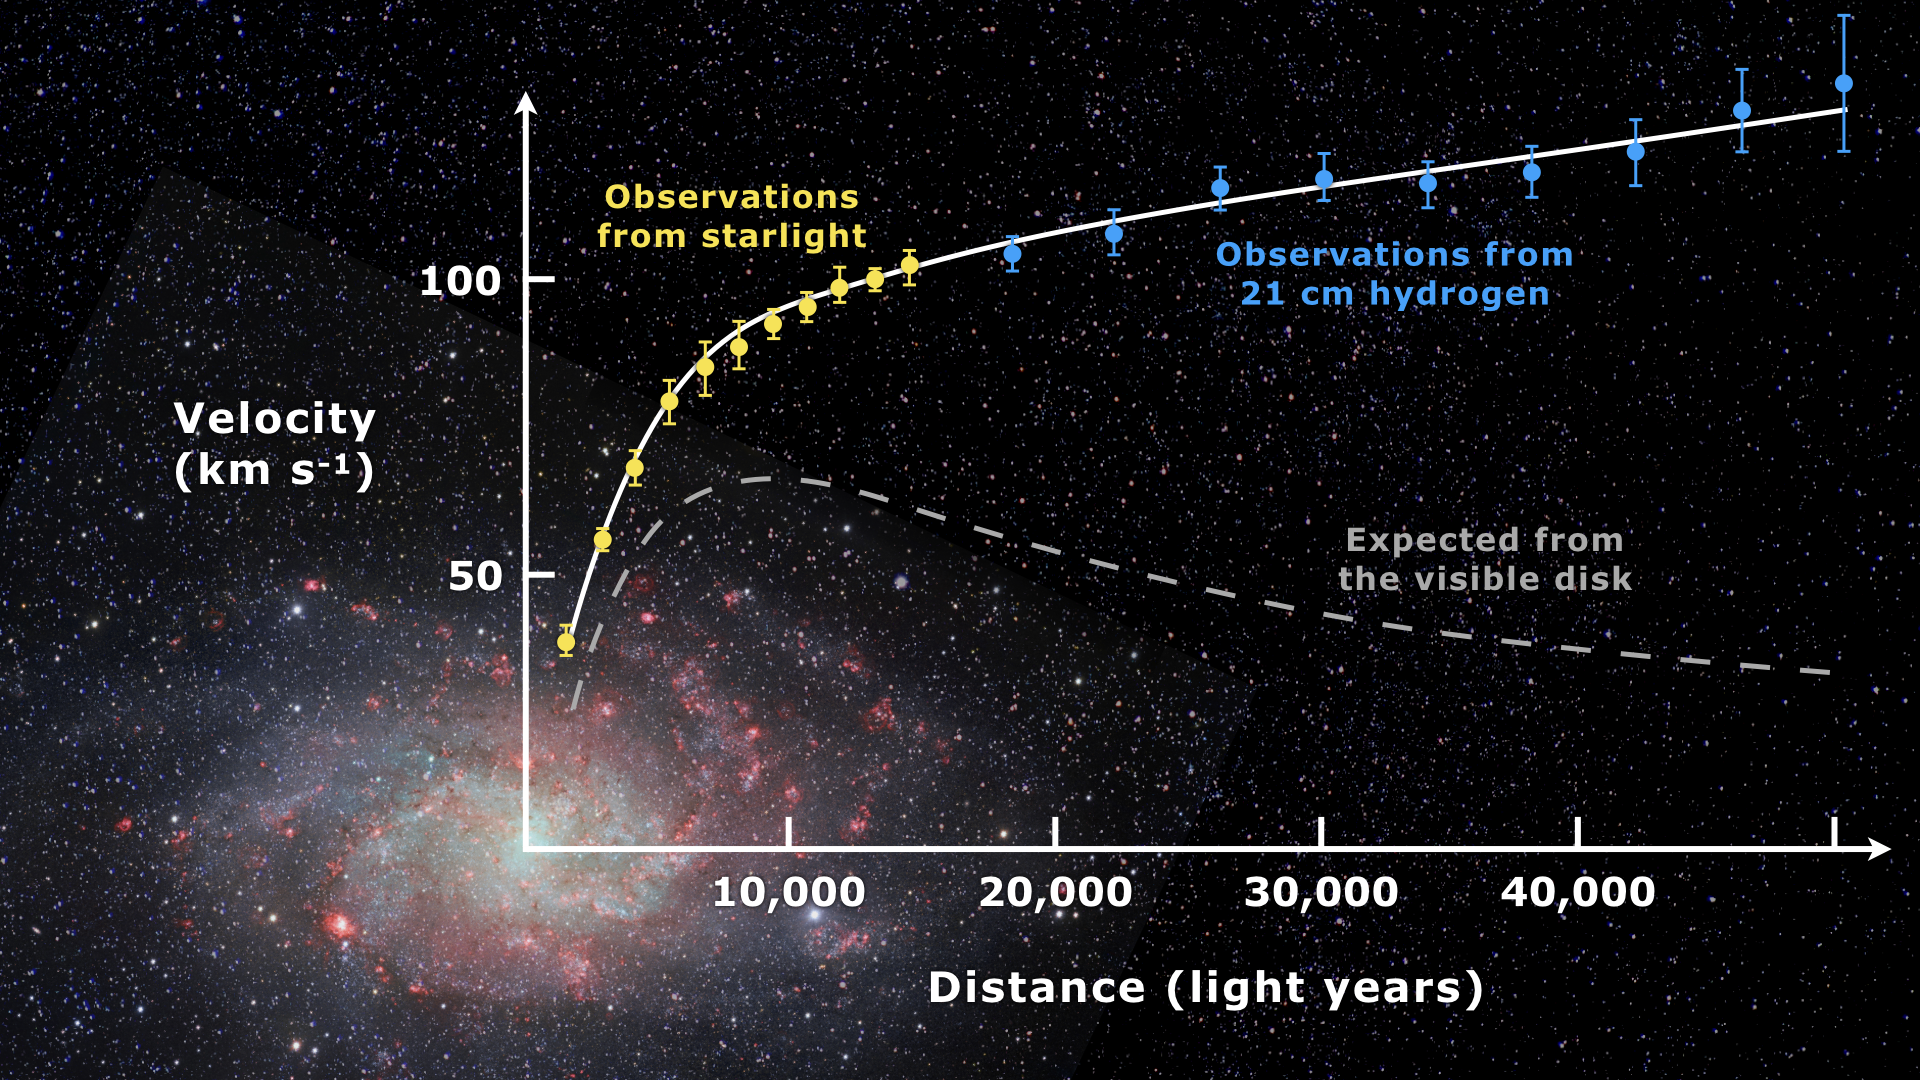
Image link: https://en.wikipedia.org/wiki/Galaxy_rotation_curve

Referring back to the line of sight figure included again below, you will notice that each line of sight crosses multiple structures in the Milky Way. For example, the l=36.5 line crosses the Sagittarius arm as well as the Scutum-Centaurus arm. Additionally, you will pick up some local neutral hydrogen surrounding our local neighborhood that moves roughly constant with the LSR. This means that there is a good chance there are multiple hydrogen clouds at different distances in your data. In order to make a rotation curve, we need to figure out how to seperate out those hydrogen clouds and assign them to a distance. For this, we will use a method called the tangent point method.

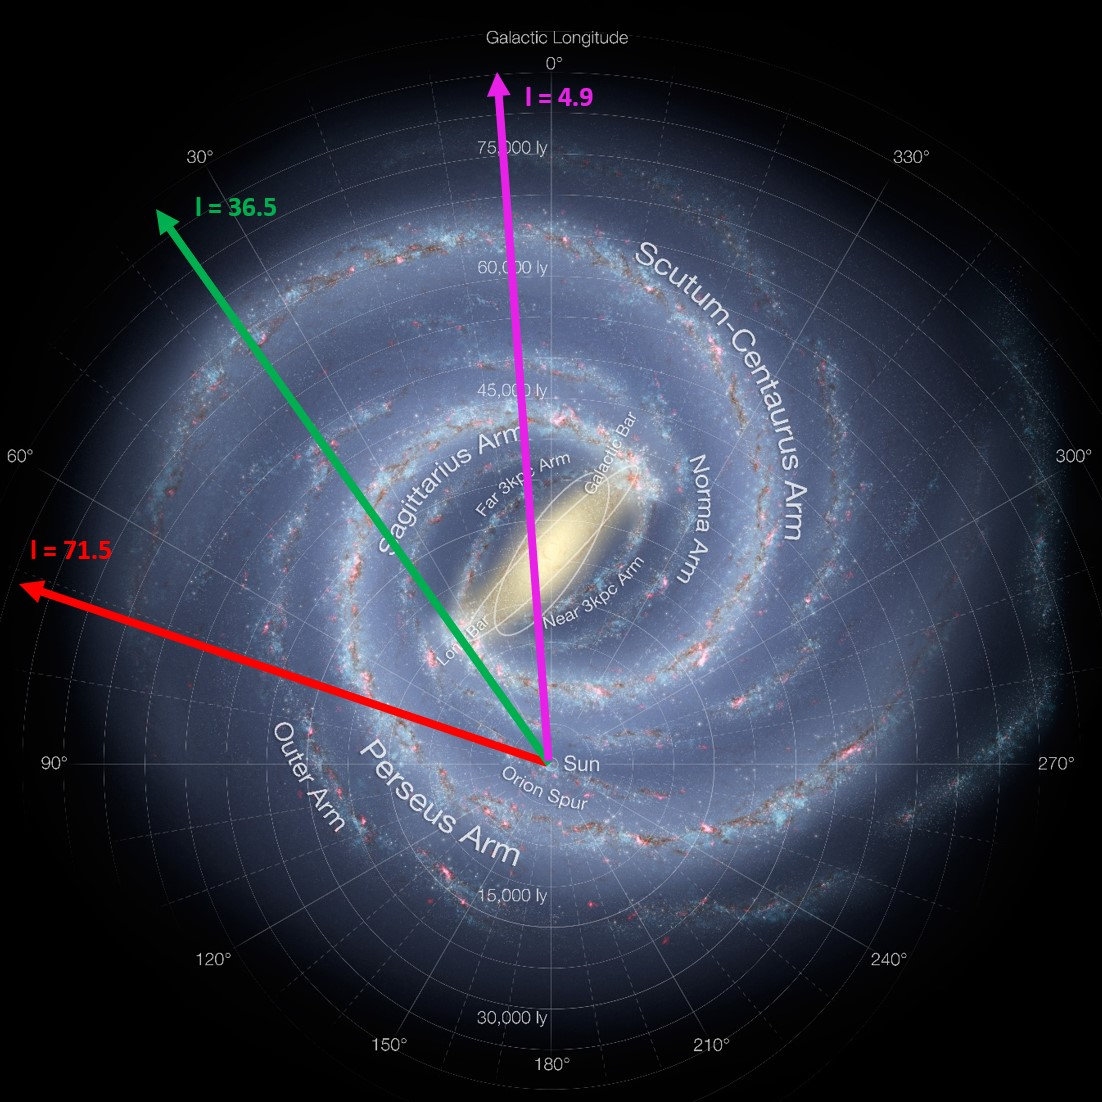

 One of the difficulties in measuring a rotation curve is that it is difficult to assign a specific velocity to a specific distance when observing multiple clouds along a line of sight. The tangent point method takes advantage of a few assumptions about the way our galaxy rotates and uses simple geometry. Our knowledge of the basic rotation of the Milky Way suggests that for matter within a solar distance from Galactic Center ($R$<$R_{sun}$), the velocity reduces with distance from Galactic Center. The solar radius has some uncertainty, but is estimated as about 8 kpc from Galactic center. The figure below shows the geometry of the tangent point method, which will also be explained mathematically.
 


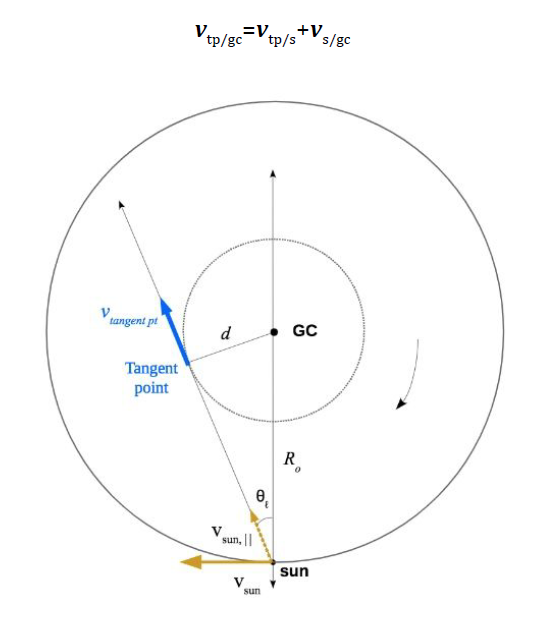


Looking at the geometry of the figure and the velocity vectors, we can see that the highest velocity away from the observer is located the the tangent point along the line of sight, which is the point where a circle drawn around the Galactic Center would intersect the line of sight. Since we have the angle of our line of sight away from the Galactic Center ($\theta_l$), which is just the galactic longitude, we can calculate the distance d from the Galactic center. Then, we associate d with the highest velocity in our data, and we now have a distance-velocity association! To det d: 

$$
    d = R_{S} \sin(\theta)
$$

where $R_{S}$ is the distance from the sun to Galactic Center and $\theta$ is the angle of of the line of sight from galactic center. We now know what distance our highest velocity cloud is at. However, we want that velocity with respect to the Galactic Center, not the observer. Then, to get the velocity of the cloud with respect to Galactic Center $V_{tpGS}$, we have

\begin{equation}
V_{tpGS} = V_{tpS} + Vs(GS) = V_{OBS} + V_{S} \sin(\theta)
\end{equation}, 

where $V_{tpS}$ is the velocity we measure with out instrument (also $V_{OBS}$), and $Vs(GS)$ is the solar velocity with respect to Galactic Center, which we know to be approximately 220 km/s. 

It is important to note that this geometry only works for lines of sight within the first and fourth Galactic quadrants. Galactic coordinates have four quadrant designations- l=0 to l=90 is the first quadrant, l=90 to l=180 the second, l=180 to l=270 the third, and l=270 to l=360 the fourth. Try to see for yourself why the geometry doesn't work for the second and third quadrants. 

At the moment, we do not have a tutorial for rotation curves with quadrants 2 and 3, so you will not be able to use pointings in those quadrants here.

Now that we have our equations, we want to find the highest velocity cloud in our data to input into the tangent point equations. How do we know what the highest velocity in the data is?

We will approcimate our velocity profiles as combined product of multiple Gaussian curves. The Gaussian curve makes a nice approximation for many types of natural phenomena, since it follows a normal distribution. Each of these Gaussians will represent a single cloud in our data, and the highest velocity Gaussian will be our tangent point cloud. For simplicity, you should only need up to four Gaussian curves to fit the data since it is unlikely that the antenna picked up more than four distinct clouds. It is important to remember that you might not need four.

The cell below will plot the data for the first pointing, and print some interactice sliders for you to use. The sliders correspond to 4 different Gaussian curves whose combined product is the fifth curve. There are only 4 curves since it is unlikely that your observations detected more than 4 hydrogen clouds. You can change the colors to your liking using the drop down menu. The “a” variable corresponds to the height of the Gaussian curve, the “b” variable corresponds to its location on the x-axis. And the “c” variable corresponds to the width of the curve. Play around with the a, b, and c values for each of the four curves, and try to match the 5th curve to your data. Once you have a fit you are happy with, write down all of the "b" values, which tell you the velocity the Gaussian curve is centered at. This time, we have three seperate cells for each of our three pointings, since the plots are interactive. If you have more than three pointings, you can copy and paste the cell below again. You will need to change the "pointing" variable to be equal to the number of the pointing you are looking at. Python indexes from 0, so pointing 1 is actually 0, and pointing 2 is 1, and so on. If you want to add a fourth pointing, copy and paste the cell and then change pointing = 3. Do that as many times as you need, and fit all your pointings.

<IPython.core.display.Javascript object>


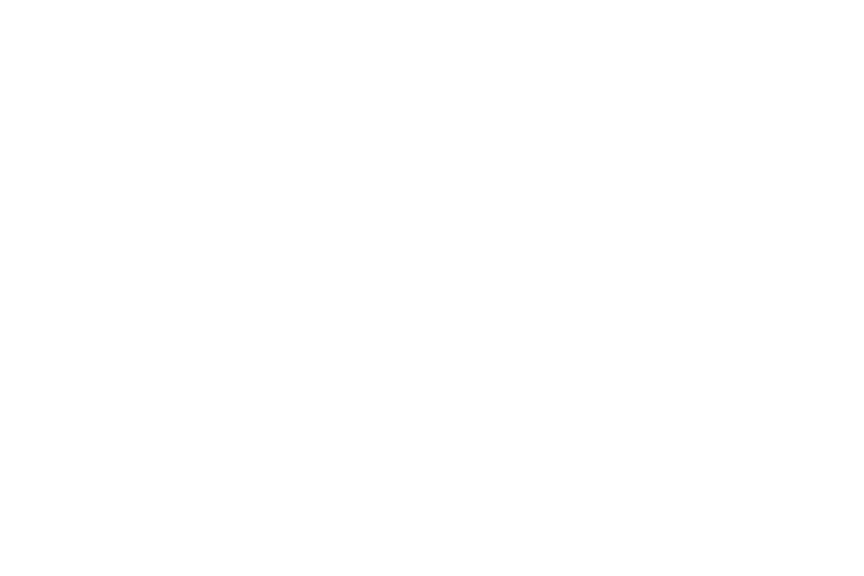

interactive(children=(FloatSlider(value=1.0, description='a1', min=-100.0, step=1.0), FloatSlider(value=1.0, d…

<function matplotlib.pyplot.show(block=None)>

In [113]:
pointing = 0

noise = noises[pointing]
gain = gains[pointing]
number = 1.4204
k_index, result = find_array_with_number(freqs, pointing, number)
sh_comp = pd.read_table(comps[pointing],skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')
compTB = sh_comp['T_B']
v_adjustment = v_adjustments[pointing]

x1 = np.array((f2v(freqs[pointing][k_index]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
y1 = np.array((10**(spectra[pointing][k_index]/10) - noise)/gain)
x2 = np.array((f2v(freqs[pointing][k_index+1]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
y2 = np.array((10**(spectra[pointing][k_index+1]/10) - noise)/gain)
unique_x, avg_y = average_overlapping(x1, y1, x2, y2)

%matplotlib notebook
ax=interactive_plot(unique_x)

ax.plot(unique_x, avg_y, 'tab:green', linewidth=2, label = 'CHART')
ax.plot(sh_comp['v_lsr'],compTB,'tab:orange', linewidth=2, label = 'Model')
plt.axvline(0, color ='k')
plt.xlim(-100,100)
ax.set_ylabel('[TB]')
ax.legend(loc='best')
plt.xlabel('Radial Velocity km/s')
plt.title('CHART HI Profile and Model Profile for l = ' + str(galactic_ls[pointing]) + ' and b = ' + str(galactic_bs[pointing]) )
plt.show

<IPython.core.display.Javascript object>


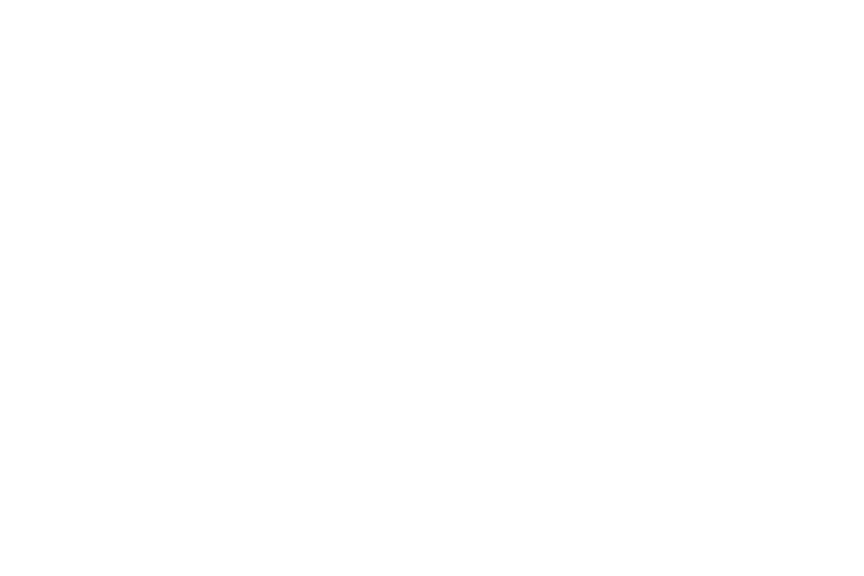

interactive(children=(FloatSlider(value=1.0, description='a1', min=-100.0, step=1.0), FloatSlider(value=1.0, d…

<function matplotlib.pyplot.show(block=None)>

In [114]:
pointing = 1

noise = noises[pointing]
gain = gains[pointing]
number = 1.4204
k_index, result = find_array_with_number(freqs, pointing, number)
sh_comp = pd.read_table(comps[pointing],skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')
compTB = sh_comp['T_B']
v_adjustment = v_adjustments[pointing]

x1 = np.array((f2v(freqs[pointing][k_index]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
y1 = np.array((10**(spectra[pointing][k_index]/10) - noise)/gain)
x2 = np.array((f2v(freqs[pointing][k_index+1]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
y2 = np.array((10**(spectra[pointing][k_index+1]/10) - noise)/gain)
unique_x, avg_y = average_overlapping(x1, y1, x2, y2)

%matplotlib notebook
ax=interactive_plot(unique_x)

ax.plot(unique_x, avg_y, 'tab:green', linewidth=2, label = 'CHART')
ax.plot(sh_comp['v_lsr'],compTB,'tab:orange', linewidth=2, label = 'Model')
plt.axvline(0, color ='k')
plt.xlim(-100,100)
ax.set_ylabel('[TB]')
ax.legend(loc='best')
plt.xlabel('Radial Velocity km/s')
plt.title('CHART HI Profile and Model Profile for l = ' + str(galactic_ls[pointing]) + ' and b = ' + str(galactic_bs[pointing]) )
plt.show

<IPython.core.display.Javascript object>


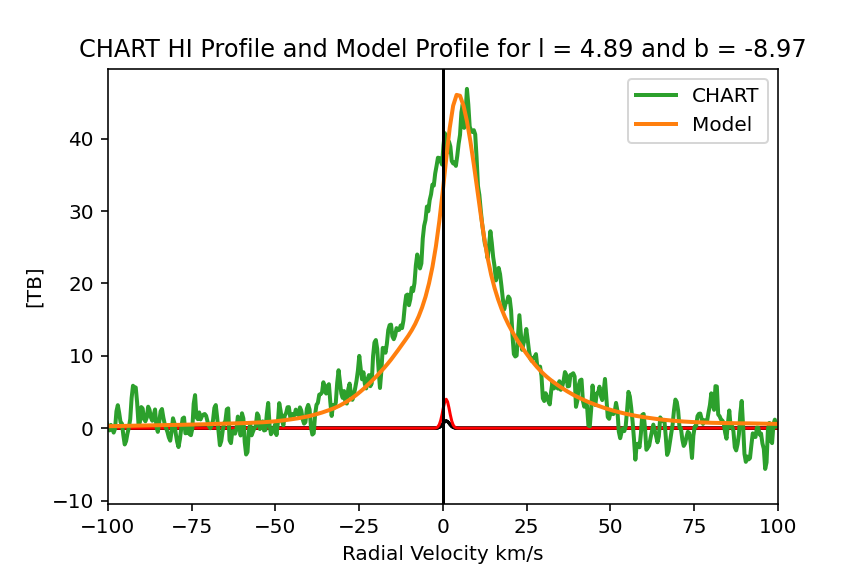

interactive(children=(FloatSlider(value=1.0, description='a1', min=-100.0, step=1.0), FloatSlider(value=1.0, d…

<function matplotlib.pyplot.show(block=None)>

In [115]:
pointing = 2

noise = noises[pointing]
gain = gains[pointing]
number = 1.4204
k_index, result = find_array_with_number(freqs, pointing, number)
sh_comp = pd.read_table(comps[pointing],skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')
compTB = sh_comp['T_B']
v_adjustment = v_adjustments[pointing]

x1 = np.array((f2v(freqs[pointing][k_index]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
y1 = np.array((10**(spectra[pointing][k_index]/10) - noise)/gain)
x2 = np.array((f2v(freqs[pointing][k_index+1]*u.GHz) / 1000)*(u.kilometer)/(u.second)-v_adjustment)
y2 = np.array((10**(spectra[pointing][k_index+1]/10) - noise)/gain)
unique_x, avg_y = average_overlapping(x1, y1, x2, y2)

%matplotlib notebook
ax=interactive_plot(unique_x)

ax.plot(unique_x, avg_y, 'tab:green', linewidth=2, label = 'CHART')
ax.plot(sh_comp['v_lsr'],compTB,'tab:orange', linewidth=2, label = 'Model')
plt.axvline(0, color ='k')
plt.xlim(-100,100)
ax.set_ylabel('[TB]')
ax.legend(loc='best')
plt.xlabel('Radial Velocity km/s')
plt.title('CHART HI Profile and Model Profile for l = ' + str(galactic_ls[pointing]) + ' and b = ' + str(galactic_bs[pointing]) )
plt.show

Now that you have separated the individual clouds in the data it is time to identify the highest-velocity cloud moving away from the observer. The terminology "highest velocity cloud" may have a sign difference depending on what galactic quadrant you're looking at.

If your data is in the first quadrant (l=0-90), then you are looking for the x-value for the highest velocity curve, (its b-value). If your data is in the fourth quadrant (l=270-360), then you are looking for the x-value for the lowest velocity curve. The reason for this disparity has to do with the direction the clouds are moving. Clouds in the first quadrant are moving away from us and are therefore redshifted. When using the Doppler equation these clouds will give us positive values. On the other hand, clouds in the fourth quadrant are moving toward us and are therefore blueshifted.  When using the Doppler equation these clouds will give us negative values. The number you will use is the absolute value of the velocity you get from this process. 

You should have written down the b values for all of your pointings.  Pick the highest positive or negative depending on the appropriate quadrant for each pointing.

Take the curve with the highest velocity (the one farthest to the right) and take its velocity (the b value) along with the galactic longitude the observation was made and input them into the arrays below.

The first line below will need to be modified to have the velocities you picked. Change the list to have the velocity values you found. Make sure you input them in the order of the pointings.

The cell will calculated the distance and velocity with respect to galactic center, and plot your rotation curve. It will also plot known rotation curve values from other scientific experiments underneath. You can see how well your data matches with the known rotation curve.

<IPython.core.display.Javascript object>


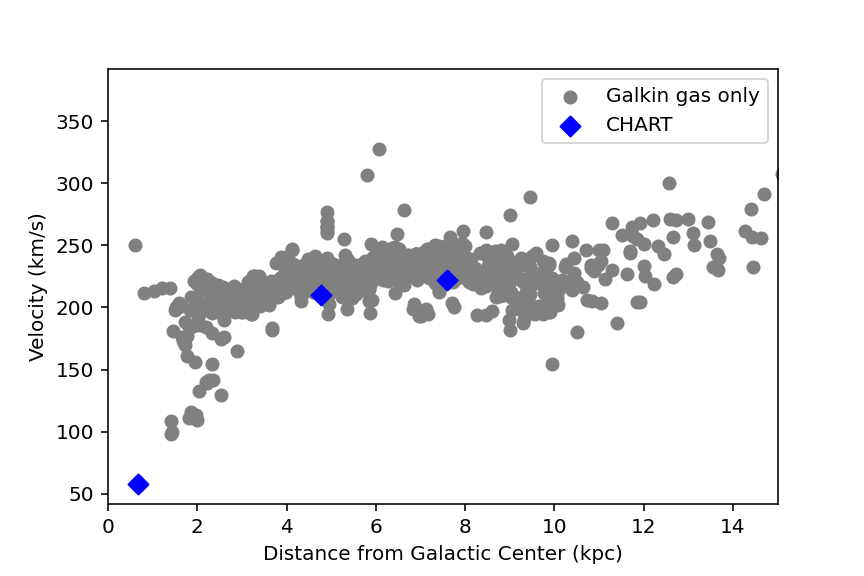

In [117]:
Vobs = np.array([4,73,38])  

%matplotlib notebook
              #observed velocity
long = galactic_ls  #galactic longitude

vcfilename = 'test_data/vcdata_baseline_gas.dat'
posfilename = 'test_data/posdata_R75.dat'

vcfile = open(vcfilename,'r')
totallistvc=[]
i=0
for line in vcfile:
    i+=1
    values=line.split()	
    if(i>2):
        totallistvc.append([float(values[0]),float(values[1]),float(values[2]),float(values[3]),float(values[4]),float(values[5]),values[6]])

posfile = open(posfilename,'r')
totallistpos=[]
i=0
for line in posfile:
    i+=1
    values=line.split()	
    if(i>2):
        totallistpos.append([float(values[0]),float(values[1]),float(values[2]),float(values[3]),float(values[4]),float(values[5]),float(values[6]),values[7]])

pos = [item[0] for item in totallistvc]
vel = [item[2] for item in totallistvc]


Vsun = 230             #estimated velocity of the sun
Ro = 8          #estimated distance of the sun to the center of the galaxy in kiloparsecs

V = Vobs + Vsun*np.sin(np.deg2rad(long)) #Calculates the tangent speed of the cloud with respect to the galactic center
d = Ro*np.sin(np.deg2rad(long))   
#Calculates the distance of the cloud from the center of the Milky Way

%matplotlib notebook
plt.scatter(pos, vel, label='Galkin gas only', alpha=1, c='gray')
plt.scatter(d, V, label='CHART', c='blue',marker='D',s=50)
plt.legend()

plt.xlim(0.,15)
plt.xlabel('Distance from Galactic Center (kpc)')
plt.ylabel('Velocity (km/s)')
plt.show()

What do you notice here? How well does your rotation curve match?